
# Neural Network Regression Notebook


## In this notebook, we use neural networks to predict stock percentage values on earnings days


In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from pandas.tseries.offsets import BDay
from datetime import datetime, timedelta
import math
import seaborn as sns
import sklearn
import time
import h5py
import copy

from seaborn import set_style
set_style("whitegrid")

import os

from bs4 import BeautifulSoup
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


In [2]:
file_path = 'C:/Users/spatan5/Desktop/New folder/final__master_data.csv'
data = pd.read_csv(file_path)
data = data[data['Ticker'] != 'ETN'] #removing erroneous ETN data


In [3]:
data.columns

Index(['File Name', 'average_volume_50_days', 'quant_score_NER',
       'financial_performance_score', 'market_position_score',
       'strategic_direction_score', 'operational_aspects_score',
       'financial_indicators_score', 'risks_challenges_score',
       'economic_factors_score', '% Change Revenue', '% Change EPS GAAP',
       '% Change EPS Normalized', 'Ticker', 'Earnings Date and Time',
       'closing_price_next_day', 'closing_price_previous_day',
       'price_7_days_before', 'price_15_days_before', 'perc_change_next_prev',
       'perc_change_prev_7', 'perc_change_7_15', 'Month'],
      dtype='object')

## In the cell below, we order the data according to Earnings Data and Time so that we can do a time based split.

#### In a previous version of this notebook, the train-test split was randomized (as is common) but some experts suggested that there might be data leakage in this case. Those experts did not provide any further justification or explanation. The results according to time based split are similar to our earlier results and we do not believe our data is time series data or that there is any evidence of data leakage.

In [4]:
data['DateTime'] = pd.to_datetime(data['Earnings Date and Time'])
data.drop('Earnings Date and Time', axis = 1, inplace=True)

#Set the 'DateTime' column as the index
data.set_index('DateTime', inplace=True)

#Sort the DataFrame by the index
data.sort_index(inplace=True)


In [5]:
data.tail(10)

,File Name,average_volume_50_days,quant_score_NER,financial_performance_score,market_position_score,strategic_direction_score,operational_aspects_score,financial_indicators_score,risks_challenges_score,economic_factors_score,...,% Change EPS Normalized,Ticker,closing_price_next_day,closing_price_previous_day,price_7_days_before,price_15_days_before,perc_change_next_prev,perc_change_prev_7,perc_change_7_15,Month
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-02-28 17:00:00,CRM2024Q4,1.788093e+07,0.674471,0.661991,0.674650,0.662010,0.407600,0.632638,0.325480,0.690156,...,0.96,CRM,308.417145,299.378906,289.342041,288.463196,3.02,3.47,0.30,2.0
2024-03-07 17:00:00,COST2024Q2,3.174563e+06,0.415311,0.455227,0.639400,0.480275,0.439291,0.547671,0.449725,0.435855,...,2.02,COST,725.559998,785.590027,744.710022,724.510010,-7.64,5.49,2.79,3.0
2024-03-07 17:15:00,AVGO2024Q1,2.831983e+06,0.661500,0.512088,0.517860,0.528526,0.066150,0.368953,0.714950,0.359367,...,5.44,AVGO,1303.170044,1401.043335,1290.733032,1259.705200,-6.99,8.55,2.46,3.0
2024-03-14 17:00:00,ADBE2024Q1,3.394506e+06,0.770712,0.699317,0.726568,0.832726,0.771257,0.771360,0.210375,0.827720,...,2.23,ADBE,492.459991,570.450012,544.840027,537.570007,-13.67,4.70,1.35,3.0
2024-03-20 16:30:00,MU2024Q2,1.910168e+07,0.588644,0.635303,0.732222,0.694736,0.567611,0.617623,-0.767700,0.785425,...,-273.75,MU,109.744064,96.157181,94.418861,89.623489,14.13,1.84,5.35,3.0
2024-03-21 08:00:00,ACN2024Q2,1.966709e+06,0.583524,0.742780,0.701747,0.781976,0.734050,0.611557,0.338590,0.645793,...,3.96,ACN,343.699188,378.972626,379.012482,373.334442,-9.31,-0.01,1.52,3.0
2024-03-21 17:00:00,NKE2024Q3,9.477026e+06,0.520158,0.644273,0.793656,0.792617,0.563729,0.518212,-0.401900,0.509721,...,29.73,NKE,93.860001,100.820000,100.180000,103.560005,-6.90,0.64,-3.26,3.0
2024-04-12 07:30:00,BLK2024Q1,5.627545e+05,0.785103,0.728500,0.791716,0.800588,0.501160,0.788917,0.548658,0.682489,...,4.47,BLK,763.400024,785.960022,814.799988,824.830017,-2.87,-3.54,-1.22,4.0
2024-04-12 10:00:00,WFC2024Q1,1.721573e+07,0.587878,0.681510,0.712719,0.727842,0.690800,0.633203,0.537273,0.634053,...,9.91,WFC,56.470001,56.689999,57.130001,57.130001,-0.39,-0.77,NaN,4.0


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical

In [7]:
all_data = data.dropna() #(should have done .copy() but I am lazy) 

In [8]:
#converting the month column to numbers via 'cyclic embeddings' - note that January is close to December so one-hot is not enough
all_data['month_sin'] = np.sin(2 * np.pi * all_data['Month']/12)
all_data['month_cos'] = np.cos(2 * np.pi * all_data['Month']/12)

C:\Users\spatan5\AppData\Local\Temp\ipykernel_1432\2186247145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['month_sin'] = np.sin(2 * np.pi * all_data['Month']/12)
C:\Users\spatan5\AppData\Local\Temp\ipykernel_1432\2186247145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['month_cos'] = np.cos(2 * np.pi * all_data['Month']/12)


In [9]:
all_data.drop(columns=['File Name', 'Month'], inplace=True)

C:\Users\spatan5\AppData\Local\Temp\ipykernel_1432\2453067428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data.drop(columns=['File Name', 'Month'], inplace=True)


In [10]:
X = all_data.drop('perc_change_next_prev', axis=1)
y = all_data['perc_change_next_prev']

In [11]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [12]:
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [13]:
preds = []
for i in range(10):
    # the 10 has been increase to 100 in the past and all results have been consistent
    # in previous version of this notebook this trained the model over many possible train-test splits
    X_train, X_test, y_train, y_test = X.iloc[:1784].copy(), X.iloc[1784:].copy(), y.iloc[:1784].copy(), y.iloc[1784:].copy()
    #df_train, df_test = df.iloc[:1784].copy(), df.iloc[1784:].copy()
    # Create a preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train_prepared = pipeline.fit_transform(X_train)
    X_test_prepared = pipeline.transform(X_test)
    # Model configuration
    input_dim = X_train_prepared.shape[1]  # Number of features
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train_prepared, y_train, epochs=100, batch_size=32, validation_split=0.2)

    y_pred = model.predict(X_test_prepared).flatten()

    preds.append([y_pred, y_test])



C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 21.0570 - val_loss: 34.0482
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9471 - val_loss: 33.7074
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3616 - val_loss: 33.3696
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0210 - val_loss: 33.0244
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.9593 - val_loss: 32.7730
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.2409 - val_loss: 32.5864
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.7841 - val_loss: 32.3657
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.5084 - val_loss: 32.2710
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8454 - val_loss: 32.2290
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4090 - val_loss: 32.0857
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7953 - val_loss: 32.1354
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20.2725 - val_loss: 34.1153
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.2586 - val_loss: 33.9296
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1532 - val_loss: 33.7560
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.7299 - val_loss: 33.5002
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2512 - val_loss: 33.2090
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1842 - val_loss: 32.8679
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.6714 - val_loss: 32.7450
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2644 - val_loss: 32.4402
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2584 - val_loss: 32.1795
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5165 - val_loss: 32.0603
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5757 - val_loss: 31.9484
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 22.4760 - val_loss: 34.0792
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3501 - val_loss: 33.8384
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.4052 - val_loss: 33.5942
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2031 - val_loss: 33.4388
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8133 - val_loss: 33.2730
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8040 - val_loss: 33.0430
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9176 - val_loss: 32.8275
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.6524 - val_loss: 32.7801
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.5417 - val_loss: 32.6516
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4430 - val_loss: 32.4923
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6890 - val_loss: 32.4716
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 21.4906 - val_loss: 33.5034
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4697 - val_loss: 33.2852
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5401 - val_loss: 33.0298
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.0860 - val_loss: 32.8636
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8296 - val_loss: 32.7611
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1410 - val_loss: 32.5975
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9126 - val_loss: 32.4774
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.6695 - val_loss: 32.4254
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7825 - val_loss: 32.4788
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0240 - val_loss: 32.5222
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1588 - val_loss: 32.4178
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.5131 - val_loss: 33.7871
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.1797 - val_loss: 33.5290
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5810 - val_loss: 33.3443
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3944 - val_loss: 33.1701
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2418 - val_loss: 33.0173
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4734 - val_loss: 32.8163
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.4725 - val_loss: 32.6674
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.0182 - val_loss: 32.5858
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5136 - val_loss: 32.4774
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7981 - val_loss: 32.4095
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3455 - val_loss: 32.2834
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 22.4860 - val_loss: 33.6137
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8949 - val_loss: 33.3608
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8091 - val_loss: 33.2246
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1621 - val_loss: 33.0988
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5429 - val_loss: 32.9767
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8716 - val_loss: 32.8686
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4500 - val_loss: 32.7343
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5716 - val_loss: 32.7283
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3154 - val_loss: 32.6790
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9853 - val_loss: 32.6721
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2110 - val_loss: 32.6119
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 21.3397 - val_loss: 34.2464
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3324 - val_loss: 33.9947
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4293 - val_loss: 33.8466
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6703 - val_loss: 33.6731
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6433 - val_loss: 33.4540
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1644 - val_loss: 33.2484
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.1446 - val_loss: 33.0189
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3222 - val_loss: 32.8725
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5812 - val_loss: 32.7558
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9510 - val_loss: 32.6587
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9569 - val_loss: 32.5907
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 20.0986 - val_loss: 33.9322
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.3526 - val_loss: 33.7710
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.5362 - val_loss: 33.5991
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2354 - val_loss: 33.3673
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9359 - val_loss: 33.1757
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.8232 - val_loss: 32.9805
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.3261 - val_loss: 32.7764
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.5070 - val_loss: 32.6129
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.4028 - val_loss: 32.5228
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.9724 - val_loss: 32.4163
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1561 - val_loss: 32.2956
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 21.9782 - val_loss: 34.2045
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2009 - val_loss: 33.9362
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.4517 - val_loss: 33.7602
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5512 - val_loss: 33.5957
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9076 - val_loss: 33.4515
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.3839 - val_loss: 33.3376
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.4091 - val_loss: 33.2767
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3881 - val_loss: 33.1873
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.6756 - val_loss: 33.0995
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1919 - val_loss: 33.1517
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5188 - val_loss: 33.1382
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

C:\Users\spatan5\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 20.6693 - val_loss: 33.8813
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2596 - val_loss: 33.6507
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5288 - val_loss: 33.4501
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7383 - val_loss: 33.2753
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1975 - val_loss: 33.1576
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0849 - val_loss: 33.0278
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.8034 - val_loss: 32.8456
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.5288 - val_loss: 32.8692
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6077 - val_loss: 32.8429
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.6079 - val_loss: 32.8140
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2584 - val_loss: 32.8015
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

# Viewing the results

In [14]:
from sklearn.metrics import mean_squared_error as mse

r2 score: -0.4783476566319209
correlation: 0.2595271194753617
mse: 47.39422320113503


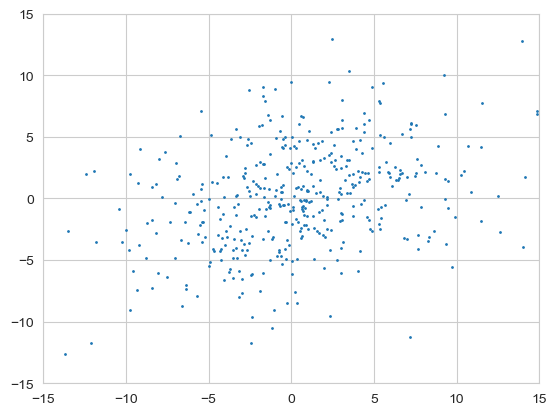

r2 score: -0.04166682372678698
correlation: 0.32913050211513467
mse: 33.39470910205299


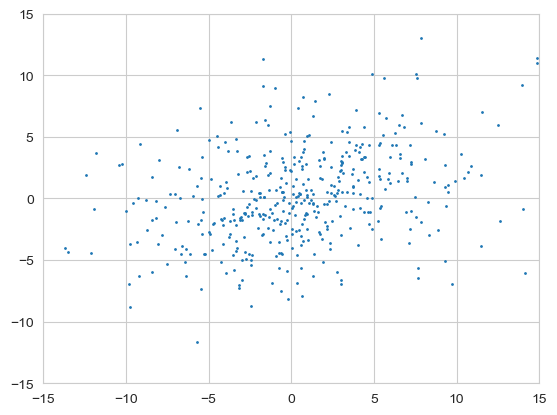

r2 score: -0.03728856904769984
correlation: 0.32501687926701095
mse: 33.25434700348897


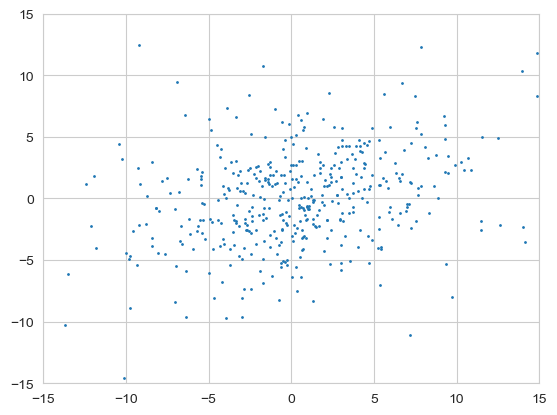

r2 score: -0.2234257471414176
correlation: 0.2294240141007302
mse: 39.2217031426407


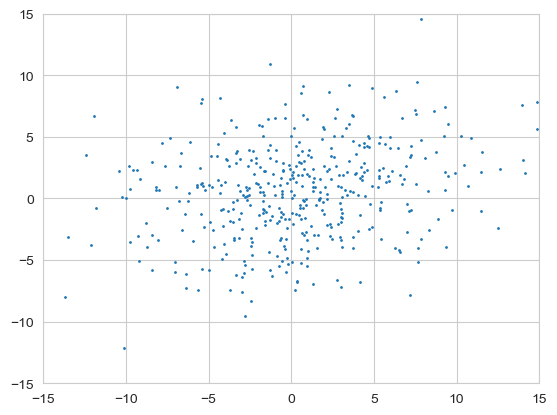

r2 score: -0.09988598832304074
correlation: 0.3131040974068072
mse: 35.26115240385711


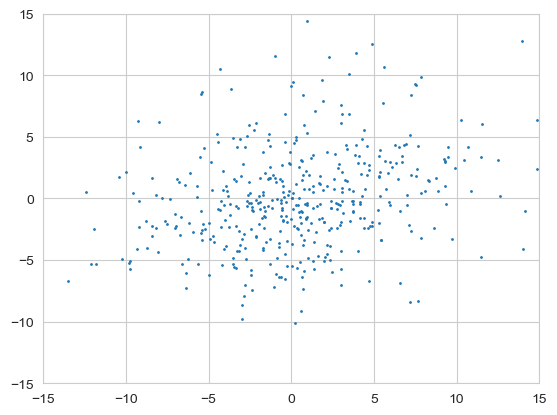

r2 score: 0.005829779185009598
correlation: 0.3757625597851008
mse: 31.872019503568485


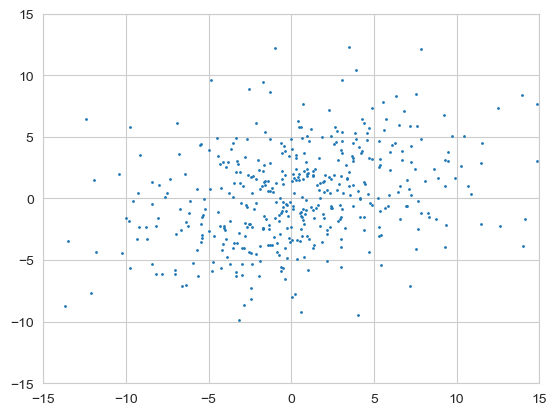

r2 score: -0.14322179826861925
correlation: 0.26994100308040875
mse: 36.650451490542835


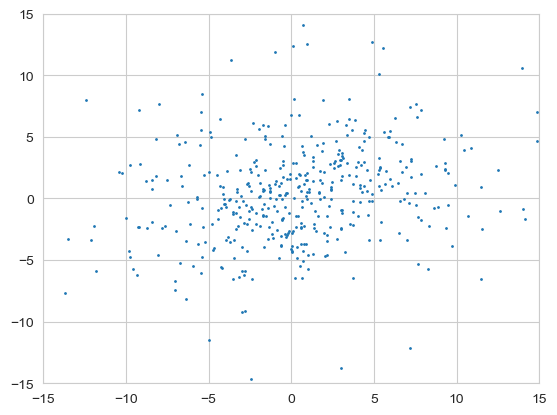

r2 score: -0.0005930083981273704
correlation: 0.36337539023541016
mse: 32.07792711056682


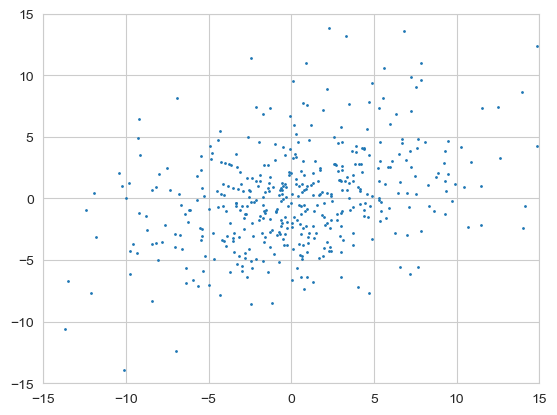

r2 score: -0.18997186835063817
correlation: 0.2765696790852843
mse: 38.14920805581778


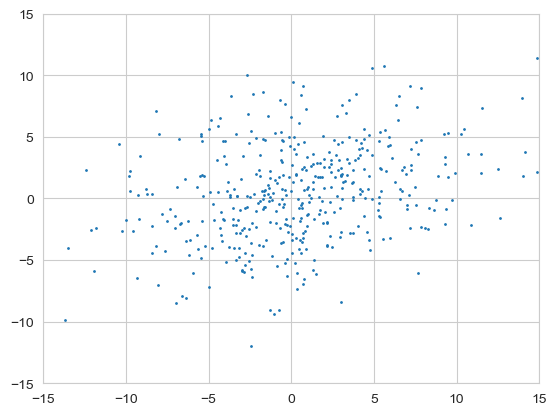

r2 score: -0.08514731089282712
correlation: 0.33402090233584963
mse: 34.78864638358275


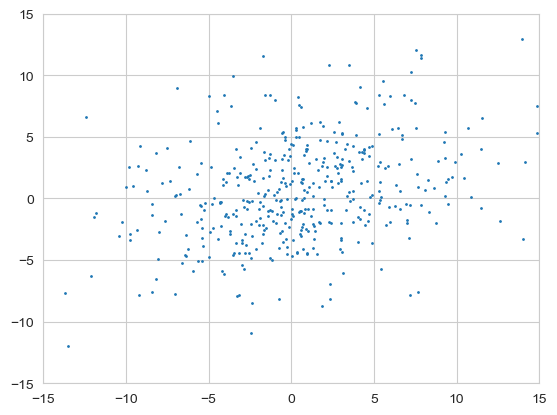

In [15]:
diffs = [] # residuls - true - predicted
r2scores = []
mses = []
corrs = []
for pred in preds:
    print("r2 score:", r2_score(y_true = pred[1], y_pred = pred[0]))
    r2scores.append(r2_score(y_true = pred[1], y_pred = pred[0]))
    print("correlation:", np.corrcoef(pred[1], pred[0])[0, 1])
    corrs.append(np.corrcoef(y_true = pred[1], y_pred = pred[0])[0, 1])
    print("mse:", mse(pred[1], pred[0]))
    mses.append(mse(pred[1], pred[0]))
    diff = pred[1] - pred[0]
    diffs.append(diff)

    plt.scatter(y_true = pred[1], y_pred = pred[0], s=1)
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.show()

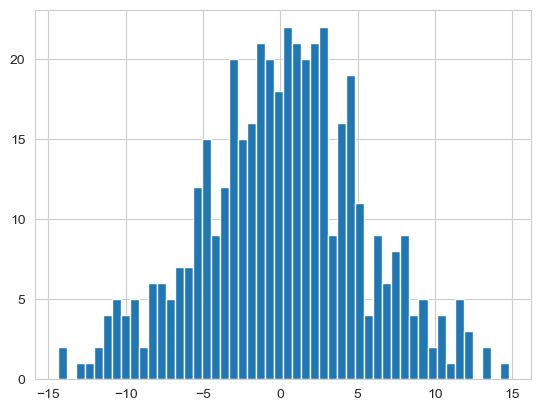

0.1922185862057679 47.46369605943467


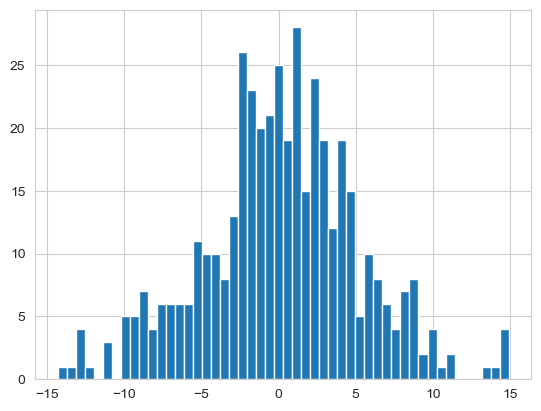

0.2871314816958701 33.38712363587724


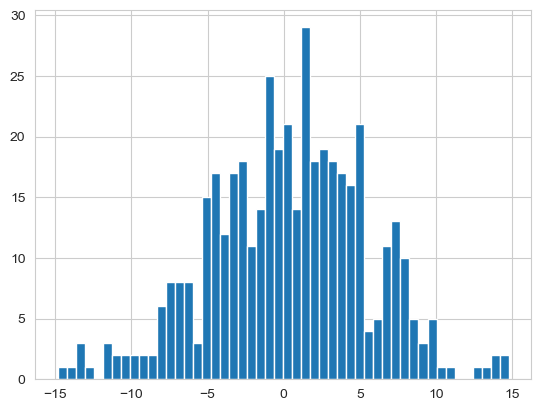

0.44855940254714183 33.12741818827075


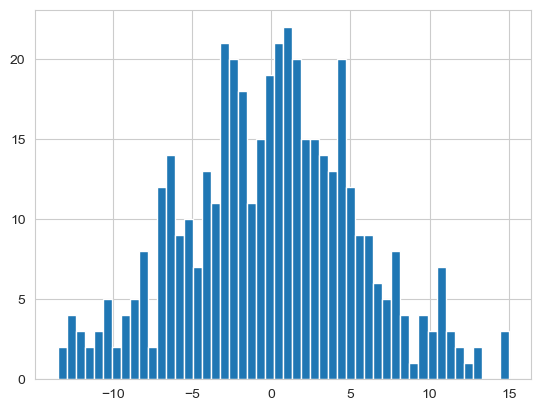

-0.1885960766405803 39.27419339209517


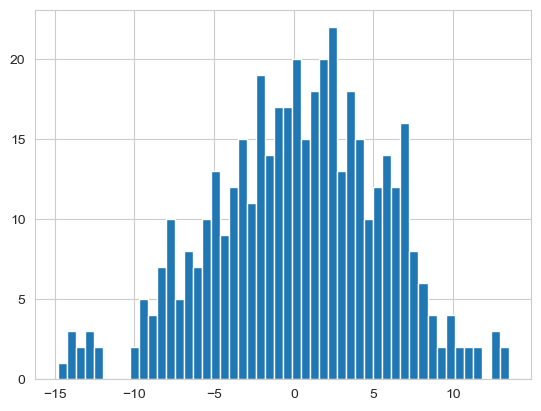

0.5326167514987057 35.05607286010451


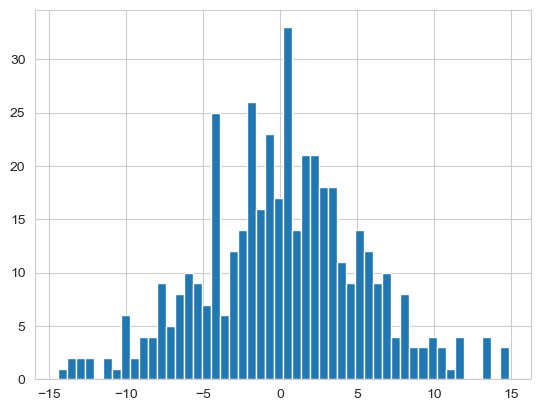

0.3225408734909088 31.839375623077142


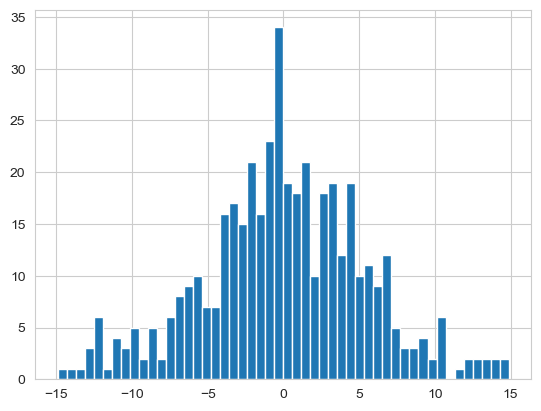

0.1682647004135521 36.70443542154464


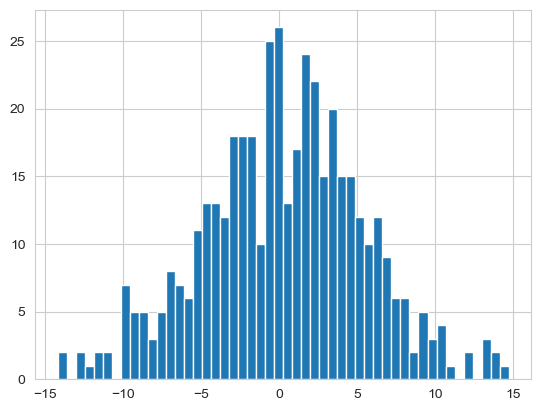

0.4052855190888649 31.985386872647933


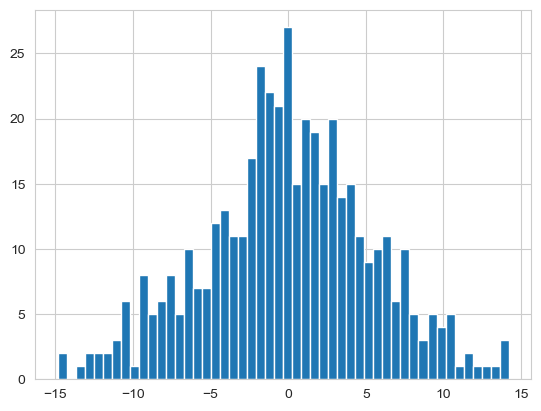

-0.08910323741624442 38.2269793850096


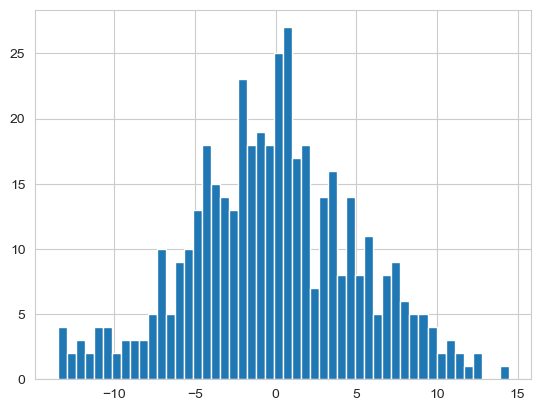

-0.15784265997564842 34.84185282451786


In [16]:
for diff in diffs:
    plt.hist([x for x in diff if -15 <= x <= 15], bins = 50)
    plt.show()
    print (diff.mean(), diff.var())

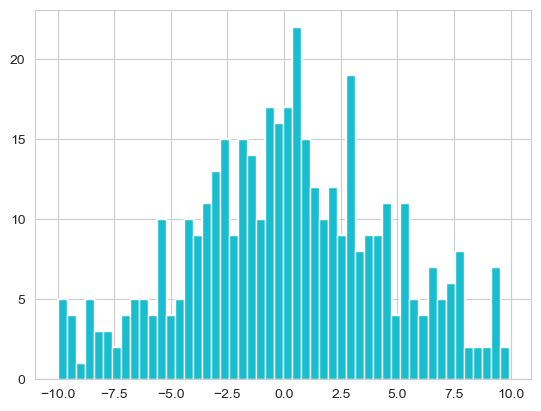

In [17]:
for pred in preds:
    plt.hist([x for x in pred[1] if -10 <= x <= 10], bins = 50)

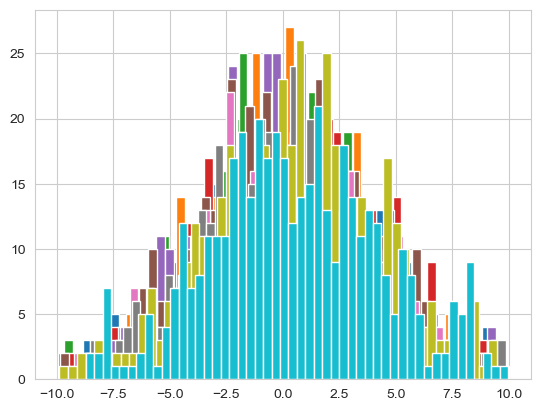

In [18]:
for pred in preds:
    plt.hist([x for x in pred[0] if -10 <= x <= 10], bins = 50)

In [19]:
sum(corrs)/len(corrs)

0.30758721468870986

In [20]:
sum(r2scores)/len(r2scores)

-0.12937189915960684

In [21]:
sum(mses)/len(mses)

36.20643873972535

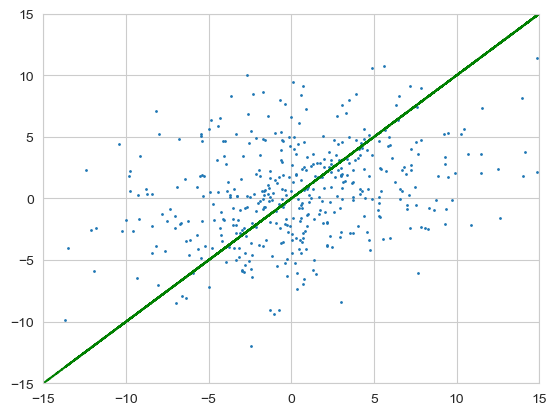

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generating some data
x = preds[8][1]
y = preds[8][0]

# Create a DataFrame
import pandas as pd
df = pd.DataFrame({'X': x, 'Y': y})

# Plotting with regplot
plt.scatter(x, y, s=1)
plt.xlim(-15,15)
plt.ylim(-15,15)
# Show the plot
df = pd.DataFrame({'X': x, 'Y': y})
plt.plot(df['X'], df['X'], color='green', linestyle='--')  # Add x=y line

plt.show()

